In [1]:
import warnings
# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from pyts.decomposition import SingularSpectrumAnalysis
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram, find_peaks
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, normaltest
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from scipy.stats import ttest_ind
import datetime
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import Counter
from sklearn.cluster import DBSCAN
import requests
from io import StringIO
from scipy.stats import spearmanr
from sklearn.metrics import mutual_info_score
from statsmodels.tsa.stattools import grangercausalitytests
from pyinform.transferentropy import transfer_entropy
from tigramite.data_processing import DataFrame as TDF
from tigramite.pcmci import PCMCI
import pyinform
from sklearn.ensemble import IsolationForest
import yfinance as yf
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
from pytrends.request import TrendReq
from fredapi import Fred
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.utils import resample
from scipy.signal import hilbert
from dtaidistance import dtw
from scipy.signal import coherence, csd
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from datetime import date, timedelta
from scipy.stats import pearsonr
import joblib
from sklearn.metrics import mean_squared_error
import pytz
from tqdm import tqdm
from scipy.stats import zscore
from scipy.ndimage import median_filter
from sklearn.metrics import precision_score, recall_score, f1_score
import ta
import pandas_datareader.data as web
from tiingo import TiingoClient
from pykalman import KalmanFilter
import ccxt
import torch.nn.functional as F
from stable_baselines3 import PPO
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from collections import deque
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import MlpExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import BaseCallback
from collections import deque
import ast
import time


pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

2025-07-25 17:03:03.496394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Базовые фукнции

In [2]:
''' FUNCTIONS '''

# Конввертируем время в привычный вариант
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

def plot_strategy_vs_buy_hold(df_signals, threshold=0.6, resample='1H', show_signals=True, max_return=10.0):
    """
    Визуализация стратегии и сравнение с Buy & Hold.

    Parameters:
    - df_signals: DataFrame с колонками ['strategy_return', 'future_return', 'signal']
    - threshold: значение, использованное при генерации сигналов
    - resample: частота агрегации ('1H', '1D', 'W', и т.д.)
    - show_signals: если True — отмечает сделки на графике
    - max_return: максимальное значение cumulative return, выше которого обрезаются выбросы
    """
    df_plot = df_signals.copy()

    # Убедимся, что индекс — datetime
    df_plot.index = pd.to_datetime(df_plot.index)
    df_plot = df_plot.sort_index()

    # Пересчитаем кумулятивные доходности
    df_plot['cumulative_return'] = (1 + df_plot['strategy_return']).cumprod()
    df_plot['buy_and_hold'] = (1 + df_plot['future_return']).cumprod()

    # Удалим выбросы
    df_plot = df_plot[(df_plot['cumulative_return'] < max_return) & (df_plot['buy_and_hold'] < max_return)]

    # Агрегация
    df_plot = df_plot.resample(resample).last()

    # График
    plt.figure(figsize=(12, 6))
    plt.plot(df_plot.index, df_plot['cumulative_return'], label='Strategy')
    plt.plot(df_plot.index, df_plot['buy_and_hold'], label='Buy & Hold', linestyle='--')
    
    # Точки входа
    if show_signals and 'signal' in df_plot.columns:
        entry_points = df_plot[df_plot['signal'] == 1]
        plt.scatter(entry_points.index, entry_points['cumulative_return'], color='green', marker='^', label='Entries', zorder=5)

    plt.title(f'Strategy vs Buy & Hold (threshold={threshold}, resample={resample})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Strategy vs Buy & Hold", dpi=300)
    plt.show()

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None, 
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None, 
             figsize = (10,4),axis_grid = 'y'):
        
    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')
    
    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)    
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

def compute_indicators_v6(df, trend_emd=None, future_horizon=5, threshold=0.02, kalman_smooth=False):

    if kalman_smooth:

        kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
        df = df.copy()
        
        for col in ['open', 'high', 'low', 'close', 'volume']:
            smoothed, _ = kf.smooth(df[col].values)
            df[col] = smoothed.flatten()
        
    price_orig = df['close']

    # Если передан тренд из EMD — использовать его как очищенную цену для индикаторов (для снижения шума)
    price = trend_emd if trend_emd is not None else price_orig

    o, h, l, c, v = df['open'], df['high'], df['low'], df['close'], df['volume']

    # --- Скользящие средние ---
    df['sma_1d'] = price
    df['sma_1w'] = price.rolling(7).mean()
    df['sma_signal'] = (df['sma_1d'] > df['sma_1w']).astype(int)

    ema12 = price.ewm(span=12, adjust=False).mean()
    ema26 = price.ewm(span=26, adjust=False).mean()
    df['ema_crossover'] = (ema12 > ema26).astype(int)

    # --- RSI ---
    delta = price.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
    df['rsi'] = 100 - (100 / (1 + rs))
    df['rsi_signal'] = (df['rsi'] < 30).astype(int)

    # --- MACD ---
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    df['macd'] = macd
    df['macd_signal'] = macd_signal
    df['macd_signal_bin'] = (macd > macd_signal).astype(int)

    # --- Volatility ---
    window_size = 7
    df['volatility_1d'] = price.rolling(window=window_size).std()
    median_vol = df['volatility_1d'].median()
    df['volatility_signal'] = (df['volatility_1d'] > median_vol).astype(int)
    vol_roll = df['volatility_1d'].rolling(14)
    df['volatility_z'] = (df['volatility_1d'] - vol_roll.mean()) / (vol_roll.std() + 1e-8)

    # --- Bollinger Bands ---
    bb = ta.volatility.BollingerBands(close=price, window=20, window_dev=2)
    df['bb_hband_indicator'] = bb.bollinger_hband_indicator()
    df['bb_lband_indicator'] = bb.bollinger_lband_indicator()

    # --- ATR ---
    df['atr'] = ta.volatility.AverageTrueRange(high=h, low=l, close=c, window=14).average_true_range()

    # --- On Balance Volume ---
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=c, volume=v).on_balance_volume()

    # --- Stochastic RSI ---
    df['stoch_rsi'] = ta.momentum.StochasticOscillator(high=h, low=l, close=c, window=14).stoch()

    # --- Новые индикаторы ---

    # ADX - сила тренда
    df['adx'] = ta.trend.ADXIndicator(high=h, low=l, close=c, window=14).adx()

    # CCI - перепроданность/перекупленность
    df['cci'] = ta.trend.CCIIndicator(high=h, low=l, close=c, window=20).cci()

    # Williams %R
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high=h, low=l, close=c, lbp=14).williams_r()

    # Parabolic SAR
    df['psar'] = ta.trend.PSARIndicator(high=h, low=l, close=c, step=0.02, max_step=0.2).psar()

    # Momentum
    df['momentum'] = c - c.shift(10)

    # Chaikin Money Flow
    df['cmf'] = ta.volume.ChaikinMoneyFlowIndicator(high=h, low=l, close=c, volume=v, window=20).chaikin_money_flow()

    # --- Свечные паттерны ---
    df['bull_candle'] = (c > o).astype(int)
    df['bear_candle'] = (c < o).astype(int)
    hl_range = h - l + 1e-8
    df['hammer'] = ((h - l > 3 * abs(o - c)) &
                    ((c - l) / hl_range > 0.6) &
                    ((o - l) / hl_range > 0.6)).astype(int)
    df['doji'] = (abs(c - o) <= 0.05 * hl_range).astype(int)
    df['shooting_star'] = ((h - l > 3 * abs(o - c)) &
                           ((h - c) / hl_range > 0.6) &
                           ((h - o) / hl_range > 0.6)).astype(int)

    prev_c, prev_o = c.shift(1), o.shift(1)
    df['bullish_engulfing'] = ((prev_c < prev_o) & (c > o) & (c > prev_o) & (o < prev_c)).astype(int)
    df['bearish_engulfing'] = ((prev_c > prev_o) & (c < o) & (c < prev_o) & (o > prev_c)).astype(int)
    df['morning_star'] = ((df['bear_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bull_candle'] == 1)).astype(int)
    df['evening_star'] = ((df['bull_candle'].shift(2) == 1) &
                          (df['doji'].shift(1) == 1) &
                          (df['bear_candle'] == 1)).astype(int)

    # --- Корреляции ---
    df['corr_price_volume_7'] = c.rolling(7).corr(v)
    df['corr_obv_price_7'] = df['obv'].rolling(7).corr(c)

    # --- Volume spike ---
    df['volume_spike'] = (v > 1.5 * v.rolling(14).mean()).astype(int)

    # --- Лаги ---
    lag_cols = ['close', 'volume', 'rsi', 'macd', 'macd_signal', 'obv', 'stoch_rsi', 'adx', 'cci', 'williams_r', 'momentum', 'cmf']
    for col in lag_cols:
        for lag in range(1, 4):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    # --- Целевая переменная ---
    df['future_return'] = df['close'].shift(-future_horizon) / df['close'] - 1
    df['target'] = (df['future_return'] > threshold).astype(int)

    # --- Свечная кластеризация ---
    candle_features = pd.DataFrame({
        'body': abs(c - o),
        'upper_shadow': h - np.maximum(c, o),
        'lower_shadow': np.maximum(0, np.minimum(c, o) - l)
    }).replace([np.inf, -np.inf], 0).fillna(0)
    candle_scaled = StandardScaler().fit_transform(candle_features)
    kmeans = KMeans(n_clusters=6, random_state=42).fit(candle_scaled)
    df['candle_cluster'] = kmeans.labels_

    # --- Комбинированный сигнал ---
    signals = ['sma_signal', 'ema_crossover', 'rsi_signal', 'macd_signal_bin', 'volatility_signal']
    df['combined_signal'] = df[signals].sum(axis=1)

    # --- Заполнение пропусков ---
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

def analyze_episode(log_path="episode_run_log.csv", trades_info=None, df_full=None, initial_balance=10_000, crypt="eth"):
    # --- Загружаем лог эпизода ---
    full_log_path = os.path.join(crypt, log_path)

    # Загружаем CSV
    df_log = pd.read_csv(full_log_path)

    steps = df_log['step']
    balances = df_log['balance']
    equities = df_log['equity']
    rewards = df_log['reward']
    positions = df_log['position']
    cumulative_rewards = np.cumsum(rewards)

    # --- Метрики ---
    total_reward = rewards.sum()
    num_trades = int(np.sum(np.abs(np.diff(positions)) > 0))
    sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8) if len(rewards) > 1 else 0
    max_dd = np.max(np.maximum.accumulate(equities) - equities)

    print(f"✅ Total reward: {total_reward:.2f}")
    print(f"🔁 Total trades executed: {num_trades}")
    print(f"📉 Max drawdown: {max_dd:.2f}")
    print(f"📈 Sharpe Ratio: {sharpe:.2f}")

    # --- Сохраняем метрики ---
    summary = pd.DataFrame([{
        'total_reward': total_reward,
        'total_trades': num_trades,
        'avg_reward': np.mean(rewards),
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'final_balance': balances.iloc[-1],
        'final_equity': equities.iloc[-1],
    }])
    summary.to_csv(f"{crypt}/episode_summary.csv", index=False)

    # --- Графики ---
    plt.figure(figsize=(14, 12))

    plt.subplot(5, 1, 1)
    plt.plot(steps, balances, label='Balance')
    plt.title('Баланс на каждом шаге')
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.legend()

    plt.subplot(5, 1, 2)
    plt.plot(steps, positions, label='Position')
    plt.title('Позиция агента (0=Hold, 1=Long)')
    plt.xlabel('Step')
    plt.ylabel('Position')
    plt.yticks([0, 1])
    plt.legend()

    plt.subplot(5, 1, 3)
    plt.plot(steps, rewards, label='Reward')
    plt.title('Награда агента по шагам')
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(steps, balances, label='Balance')
    plt.plot(steps, equities, label='Equity')
    plt.title('📉 Equity и баланс за эпизод')
    plt.xlabel('Step')
    plt.ylabel('USD')
    plt.legend()
    plt.grid(True)

    plt.subplot(5, 1, 5)
    plt.plot(steps, cumulative_rewards, label='Кумулятивная прибыль')
    plt.title('Кумулятивная прибыль')
    plt.xlabel('Step')
    plt.ylabel('Profit')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{crypt}/episode_plots.png")
    plt.show()

    # --- Сравнение с Buy & Hold ---
    if df_full is not None:
        plt.figure(figsize=(12, 6))
        bh_equity = df_full['close'].iloc[:len(steps)] / df_full['close'].iloc[0] * initial_balance
        plt.plot(steps, equities, label='RL Strategy')
        plt.plot(steps, bh_equity, label='Buy & Hold', linestyle='--')
        plt.title("📊 RL стратегия vs Buy & Hold")
        plt.xlabel("Шаг")
        plt.ylabel("USD")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{crypt}/rl_vs_hold.png")
        plt.show()

    # --- Анализ сделок ---
    if trades_info:
        trades_df = pd.DataFrame(trades_info)
        trades_df['duration'] = trades_df['exit_step'] - trades_df['entry_step']
        trades_df.to_csv(f"{crypt}/trades.csv", index=False)

        print(f"\nОбщее число сделок: {len(trades_df)}")
        print(f"Средняя длительность сделки (в шагах): {trades_df['duration'].mean():.2f}")
        print(f"Средняя прибыль на сделку: {trades_df['profit'].mean():.2f}")
        print(f"Суммарная прибыль: {trades_df['profit'].sum():.2f}")

        # Гистограмма прибыли
        plt.figure(figsize=(12, 4))
        plt.hist(trades_df['profit'], bins=30, color='blue', alpha=0.7)
        plt.title("Распределение прибыли по сделкам")
        plt.xlabel("Прибыль")
        plt.ylabel("Частота")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{crypt}/trade_profit_hist.png")
        plt.show()

    # # Цена BTC с входами/выходами
    # if df_full is not None:
    #     plt.figure(figsize=(14, 6))
    #     plt.plot(df_full.index, df_full['Close'], label='Цена BTC', color='black', alpha=0.6)

    #     for trade in trades_info:
    #         entry = trade['entry_step']
    #         exit_ = trade['exit_step']
    #         profit = trade['profit']
    #         color = 'green' if profit >= 0 else 'red'
    #         plt.axvline(df_full.index[entry], color=color, linestyle='--', alpha=0.5)
    #         plt.axvline(df_full.index[exit_], color=color, linestyle=':', alpha=0.5)

    #     plt.title("📈 Цена BTC с точками входа/выхода")
    #     plt.xlabel("Время")
    #     plt.ylabel("Цена")
    #     plt.grid(True)
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("btc_price_with_trades.png")
    #     plt.show()

def analyze_summary_metrics(run_logs: list[pd.DataFrame], trades_infos: list[list[dict]]):
    rewards_all = []
    sharpe_all = []
    drawdowns_all = []
    num_trades_all = []
    avg_pnl_all = []
    avg_duration_all = []

    for log_df, trades in zip(run_logs, trades_infos):
        # === Награды и Sharpe ===
        rewards = log_df['reward'].values
        total_reward = np.sum(rewards)
        sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8)
        equity = log_df['equity'].values
        max_dd = np.max(np.maximum.accumulate(equity) - equity)

        rewards_all.append(total_reward)
        sharpe_all.append(sharpe)
        drawdowns_all.append(max_dd)

        # === Trades ===
        trades_df = pd.DataFrame(trades)
        num_trades_all.append(len(trades_df))
        avg_pnl_all.append(trades_df['profit'].mean() if not trades_df.empty else 0)
        avg_duration_all.append(trades_df['exit_step'].sub(trades_df['entry_step']).mean() if not trades_df.empty else 0)

    print("📊 Метрики по всем эпизодам:")
    print(f"▶ Средняя Total Reward: {np.mean(rewards_all):.2f}")
    print(f"▶ Средний Sharpe Ratio: {np.mean(sharpe_all):.2f}")
    print(f"▶ Средний Max Drawdown: {np.mean(drawdowns_all):.2f}")
    print(f"▶ Среднее число сделок: {np.mean(num_trades_all):.2f}")
    print(f"▶ Средняя прибыль на сделку: {np.mean(avg_pnl_all):.2f}")
    print(f"▶ Средняя длительность сделки: {np.mean(avg_duration_all):.2f} шагов")

    # --- Визуализация ---
    fig, axs = plt.subplots(2, 3, figsize=(16, 8))

    axs[0,0].boxplot(rewards_all)
    axs[0,0].set_title('🎯 Total Reward')
    
    axs[0,1].boxplot(sharpe_all)
    axs[0,1].set_title('📈 Sharpe Ratio')
    
    axs[0,2].boxplot(drawdowns_all)
    axs[0,2].set_title('📉 Max Drawdown')
    
    axs[1,0].boxplot(num_trades_all)
    axs[1,0].set_title('💼 Num Trades')
    
    axs[1,1].boxplot(avg_pnl_all)
    axs[1,1].set_title('💰 Avg PnL per Trade')
    
    axs[1,2].boxplot(avg_duration_all)
    axs[1,2].set_title('⏱️ Avg Trade Duration')

    plt.tight_layout()
    plt.show()

def test(vec_env, model, df, crypt="eth"):

    if crypt !="eth" and crypt != "sol":
        print("Такую крипту не теcтируем")

    else:
    
        obs = vec_env.reset()
        done = False
        
        balances = []
        positions = []
        rewards = []
        steps = []
        equities = []
        
        total_reward = 0
        step_idx = 0
        num_trades = 0
        last_position = 0
        
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = vec_env.step(action)
        
            balance = info[0]['balance']
            position = info[0]['position']
            equity = info[0].get('equity', balance)  # fallback на balance
        
            balances.append(balance)
            positions.append(position)
            rewards.append(reward[0])
            equities.append(equity)
            steps.append(step_idx)
        
            # Считаем сделки — смена позиции
            if position != last_position:
                num_trades += 1
                last_position = position
        
            total_reward += reward[0]
            step_idx += 1
        
        print(f"✅ {crypt} Total reward for episode: {total_reward:.2f}")
        print(f"🔁 {crypt} Total trades executed: {num_trades}")
        
        # --- Метрики ---
        if len(equities) > 1:
            equity_array = np.array(equities)
            max_dd = np.max(np.maximum.accumulate(equity_array) - equity_array)
            sharpe = np.mean(rewards) / (np.std(rewards) + 1e-8)
        
            print(f"📉 Max drawdown: {max_dd:.2f}")
            if len(rewards) > 1:
                print(f"📈 Sharpe Ratio: {sharpe:.2f}")
        
        # Сохраняем в CSV
        df_log = pd.DataFrame({
            'step': steps,
            'balance': balances,
            'equity': equities,
            'position': positions,
            'reward': rewards
        })
        df_log.to_csv(f'{crypt}/episode_run_log.csv', index=False)
        print(f"Логи эпизода сохранены в {crypt}/episode_run_log.csv")
        
        hold_lengths = []
        current_hold = 0
        
        for pos in positions:
            if pos == 1:
                current_hold += 1
            else:
                if current_hold > 0:
                    hold_lengths.append(current_hold)
                    current_hold = 0
        
        plt.hist(hold_lengths, bins=30)
        plt.title("Длительность удержания позиции (в шагах)")
        plt.xlabel("Шаги")
        plt.ylabel("Частота")
        plt.show()
        
        all_trades = vec_env.envs[0].all_trades_info
        analyze_episode(
            log_path="episode_run_log.csv",
            trades_info=all_trades,
            df_full=df,  # или df, где есть .index и 'Close'
            crypt = crypt
        )
        
        run_logs = []
        trades_infos = []
        
        obs = vec_env.reset()
        log = {"balance": [], "equity": [], "reward": [], "position": [], "step": []}
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = vec_env.step(action)
            info = info[0]
        
            for key in log:
                if key == "reward":
                    log[key].append(reward[0])
                else:
                    log[key].append(info[key])
        
        run_logs.append(pd.DataFrame(log))
        
        # Вместо trades_infos.append(...)
        trades_infos.append(vec_env.envs[0].all_trades_info)  # Без цикла
        
        # --- Анализ всех эпизодов ---
        analyze_summary_metrics(run_logs, trades_infos)
        
        try:
            raw_env = vec_env.envs[0]
        except AttributeError:
            raw_env = vec_env.venv.envs[0]
        
        trades_df = pd.DataFrame(raw_env.all_trades_info)
        
        # Визуализация трейдов (если есть)
        fig, axs = plt.subplots(2, 2, figsize=(14, 10))
        
        
        if not trades_df.empty:
            axs[0, 0].bar(range(len(trades_df)), trades_df["profit"])
            axs[0, 0].set_title("📈 Прибыль по сделкам")
            axs[0, 0].set_xlabel("Сделка #")
            axs[0, 0].set_ylabel("Profit")
        
            axs[0, 1].bar(range(len(trades_df)), trades_df["holding"])
            axs[0, 1].set_title("⏱️ Длительность сделок")
            axs[0, 1].set_xlabel("Сделка #")
            axs[0, 1].set_ylabel("Steps held")
        
            axs[1, 0].scatter(trades_df["holding"], trades_df["profit"])
            axs[1, 0].set_title("📉 Профит от длительности")
            axs[1, 0].set_xlabel("Holding steps")
            axs[1, 0].set_ylabel("Profit")
        
            sns.histplot(trades_df["profit"], bins=15, kde=True, ax=axs[1, 1])
            axs[1, 1].set_title("📊 Распределение прибыли")
        
            plt.tight_layout()
            plt.savefig(f"{crypt}/сделки.png")
            plt.show()
        else:
            print("❌ Сделок нет (trades_info пуст). Агент не торговал.")
        
        # Генерация теплокарты метрик по reward_scaling и holding_penalty
        # Синтетически: создадим грид и оценим "усреднённый" PnL
        reward_scalings = [10, 100, 500, 1000]
        holding_penalties = [0.0005, 0.001, 0.002, 0.005]
        
        # Простая функция оценки (заглушка, не реальное обучение)
        def dummy_pnl(reward_scaling, holding_penalty):
            return (reward_scaling / 100) - (holding_penalty * 1000)
        
        heatmap_data = np.array([
            [dummy_pnl(r, h) for r in reward_scalings]
            for h in holding_penalties
        ])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(heatmap_data, xticklabels=reward_scalings, yticklabels=holding_penalties, annot=True, fmt=".1f", cmap="YlGnBu")
        plt.title("🔥 'Скоринговая' теплокарта: reward_scaling vs holding_penalty")
        plt.xlabel("reward_scaling")
        plt.ylabel("holding_penalty")
        plt.savefig(f"{crypt}/heatmap_data.png")
        plt.show()
        
        
        try:
            raw_env = vec_env.envs[0]
        except AttributeError:
            raw_env = vec_env.venv.envs[0]
        
        trades_df = pd.DataFrame(raw_env.all_trades_info)
        print(trades_df[['entry_step', 'exit_step', 'profit', 'holding', 'entry_price', 'exit_price']].describe())
        
        run_logs = []
        trades_infos = []   


# Модель и классы RL агента

In [3]:
class SOLTradingEnv(gym.Env):
    def __init__(self, df, state_columns,
             initial_balance=10_000,
             trade_penalty=0.01,
             max_steps=None,
             reward_scaling=100.0,
             use_log_return=False,
             use_sharpe_bonus=False,
             holding_penalty=0.005,
             sharpe_bonus_weight=0.5,
             commission=0.0005,
             spread=0.0002,
             slippage_std=0.001,
             min_holding_period=8,
             window_size=672):

        super().__init__()
        self.df = df.reset_index(drop=True)
        self.state_columns = state_columns
        self.window_size = window_size

        self.commission = commission
        self.spread = spread
        self.slippage_std = slippage_std
        self.min_holding_period = min_holding_period

        self.action_space = gym.spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, len(state_columns)),
            dtype=np.float32
        )

        self.initial_balance = initial_balance
        self.trade_penalty = trade_penalty
        self.reward_scaling = reward_scaling
        self.max_steps = max_steps if max_steps is not None else len(df) - 1

        self.use_log_return = use_log_return
        self.use_sharpe_bonus = use_sharpe_bonus
        self.holding_penalty = holding_penalty
        self.sharpe_bonus_weight = sharpe_bonus_weight

        self.all_trades_info = []
        self.episode_trades_info = []
        self.negative_steps_log = []

        self.reset()

    def _get_execution_price(self, price, action):
        if action == 1:
            exec_price = price * (1 + self.spread)
        elif action == 2:
            exec_price = price * (1 - self.spread)
        else:
            exec_price = price

        slippage = np.random.normal(0, self.slippage_std)
        exec_price *= (1 + slippage)
        return max(exec_price, 0.0001)

    def save_negative_steps(self, path="negative_steps_log.csv"):
        if self.negative_steps_log:
            df_neg = pd.DataFrame(self.negative_steps_log)
            df_neg.to_csv(path, index=False)
            print(f"[✓] Сохранён лог негативных шагов в {path}")
        else:
            print("[i] Нет негативных шагов для сохранения.")

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][self.state_columns].astype(np.float32).values
        obs = np.nan_to_num(obs)
        self.state_window.append(obs)
        return np.array(self.state_window)

    def _calculate_equity(self, current_price):
        if self.position == 1:
            return self.balance + (current_price - self.entry_price)
        return self.balance

    def _calculate_max_drawdown(self):
        equity = np.array(self.equity_curve)
        if len(equity) < 2:
            return 0
        cumulative_max = np.maximum.accumulate(equity)
        drawdowns = (equity - cumulative_max) / cumulative_max
        return drawdowns.min()

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.entry_step = None
        self.total_reward = 0.0
        self.trades = []
        self.trades_info = []
        self.equity_curve = [self.balance]
        self.episode_trades_info = []
        self.actions_log = []
        self.state_window = deque(maxlen=self.window_size)
        self.invalid_sell_count = 0
        self.invalid_buy_count = 0
        self.negative_steps_log = []

        for i in range(self.current_step - self.window_size, self.current_step):
            obs = self.df.iloc[i][self.state_columns].astype(np.float32).values
            self.state_window.append(np.nan_to_num(obs))

        return self._next_observation(), {}

    def step(self, action):
        done = False
        reward = 0.0
    
        market_price = self.df.loc[self.current_step, 'close']
        if np.isnan(market_price) or market_price <= 0:
            market_price = 1.0
    
        max_holding_period = 96
        if self.position == 1 and (self.current_step - self.entry_step) >= max_holding_period:
            action = 2  # форсированная продажа
    
        exec_price = self._get_execution_price(market_price, action)
    
        # --- BUY ---
        if action == 1:
            if self.position == 0:
                commission_cost = exec_price * self.commission
                reward += 0.2
                self.position = 1
                self.entry_price = exec_price + commission_cost
                self.entry_step = self.current_step
                self.balance -= commission_cost
            else:
                self.invalid_buy_count += 1
                reward -= 0.01 * self.invalid_buy_count
    
        # --- SELL ---
        elif action == 2:
            if self.position == 1:
                commission_cost = exec_price * self.commission
                price_change = (exec_price - self.entry_price) / self.entry_price
                holding_duration = self.current_step - self.entry_step
    
                reward = price_change * 100
                reward -= self.commission * 2
                reward += 0.3
    
                if holding_duration < self.min_holding_period:
                    reward -= 0.05
    
                self.balance += price_change * self.entry_price
                self.balance -= commission_cost
    
                trade_info = {
                    "entry_step": self.entry_step,
                    "exit_step": self.current_step,
                    "profit": price_change - self.commission * 2,
                    "holding": holding_duration,
                    "entry_price": self.entry_price,
                    "exit_price": exec_price
                }
                self.trades.append(trade_info["profit"])
                self.episode_trades_info.append(trade_info)
                self.all_trades_info.append(trade_info)
    
                self.position = 0
                self.entry_price = 0.0
                self.entry_step = None
            else:
                self.invalid_sell_count += 1
                reward -= 0.01 * self.invalid_sell_count
    
        # --- HOLD ---
        elif action == 0:
            if self.position == 1:
                unrealized = (market_price - self.entry_price) / self.entry_price
                reward += unrealized * 0.1
    
                holding_duration = self.current_step - self.entry_step
                if holding_duration > self.min_holding_period:
                    reward -= self.holding_penalty * 0.5 * max(0, holding_duration - self.min_holding_period)
            else:
                reward -= 0.001
    
        # --- Reset bad action counters if action was good ---
        if (action == 1 and self.position == 0) or (action == 2 and self.position == 1) or action == 0:
            self.invalid_sell_count = 0
            self.invalid_buy_count = 0
    
        # --- Clip and finalize ---
        reward = np.clip(reward, -100.0, 100.0)
        if np.isnan(reward) or np.isinf(reward):
            reward = 0.0
    
        equity = self._calculate_equity(market_price)
        self.total_reward += reward
        self.equity_curve.append(equity)
    
        obs = self._next_observation()
        self.current_step += 1
        done = self.current_step >= self.max_steps
    
        # --- Force close ---
        if done and self.position == 1:
            exec_price = self._get_execution_price(market_price, 2)
            commission_cost = exec_price * self.commission
            final_price_change = (exec_price - self.entry_price) / self.entry_price - self.commission * 2
            final_reward = final_price_change
    
            self.balance += final_price_change * self.entry_price
            self.balance -= commission_cost
    
            trade_info = {
                "entry_step": self.entry_step,
                "exit_step": self.current_step,
                "profit": final_price_change,
                "holding": self.current_step - self.entry_step,
                "entry_price": self.entry_price,
                "exit_price": exec_price
            }
            self.trades.append(final_price_change)
            self.episode_trades_info.append(trade_info)
            self.all_trades_info.append(trade_info)
    
            self.total_reward += final_reward * self.reward_scaling
            self.position = 0
    
        # --- Sharpe bonus ---
        if done and self.use_sharpe_bonus and len(self.trades) > 1:
            sharpe = np.mean(self.trades) / (np.std(self.trades) + 1e-8)
            reward += self.sharpe_bonus_weight * sharpe
    
        self.actions_log.append(action)
    
        # --- INFO ---
        info = {
            'balance': self.balance,
            'equity': equity,
            'position': self.position,
            'step': self.current_step,
            'reward': reward,
            'drawdown': self._calculate_max_drawdown(),
            'total_profit': np.sum(self.trades),
            'recent_trade': self.episode_trades_info[-1] if self.episode_trades_info else None,
            'entry_price': self.entry_price if self.position == 1 else None,
            'unrealized_profit': ((market_price - self.entry_price) / self.entry_price) if self.position == 1 else 0.0,
            'holding_duration': (self.current_step - self.entry_step) if self.position == 1 else 0,
            'actions_log': self.actions_log[-100:]
        }
    
        if done and self.episode_trades_info:
            profits = [t["profit"] for t in self.episode_trades_info]
            durations = [t["holding"] for t in self.episode_trades_info]
    
            avg_profit = np.mean(profits)
            avg_duration = np.mean(durations)
            sharpe_ratio = np.mean(profits) / (np.std(profits) + 1e-8)
    
            tp = sum(1 for p in profits if p > 0)
            fp = sum(1 for p in profits if p <= 0)
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (len(profits) + 1e-8)
    
            info.update({
                "avg_trade_profit": avg_profit,
                "avg_holding_duration": avg_duration,
                "sharpe_ratio": sharpe_ratio,
                "precision": precision,
                "recall": recall,
                "f1_score": 2 * precision * recall / (precision + recall + 1e-8)
            })
    
        if reward < 0:
            self.negative_steps_log.append({
                "step": self.current_step,
                "reward": reward,
                "action": action,
                "position": self.position,
                "balance": self.balance,
                "equity": equity,
            })
    
        return obs, reward, done, False, info

In [4]:
class ETHTradingEnv(gym.Env):
    def __init__(self, df, state_columns,
             initial_balance=10_000,
             trade_penalty=0.01,
             max_steps=None,
             reward_scaling=100.0,
             use_log_return=False,
             use_sharpe_bonus=False,
             holding_penalty=0.005,
             sharpe_bonus_weight=0.5,
             commission=0.0005,
             spread=0.0002,
             slippage_std=0.001,
             min_holding_period=8,
             window_size=672):

        super().__init__()
        self.df = df.reset_index(drop=True)
        self.state_columns = state_columns
        self.window_size = window_size

        self.commission = commission
        self.spread = spread
        self.slippage_std = slippage_std
        self.min_holding_period = min_holding_period

        self.action_space = gym.spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, len(state_columns)),
            dtype=np.float32
        )

        self.initial_balance = initial_balance
        self.trade_penalty = trade_penalty
        self.reward_scaling = reward_scaling
        self.max_steps = max_steps if max_steps is not None else len(df) - 1

        self.use_log_return = use_log_return
        self.use_sharpe_bonus = use_sharpe_bonus
        self.holding_penalty = holding_penalty
        self.sharpe_bonus_weight = sharpe_bonus_weight

        self.all_trades_info = []
        self.episode_trades_info = []
        self.negative_steps_log = []

        self.reset()

    def _get_execution_price(self, price, action):
        if action == 1:
            exec_price = price * (1 + self.spread)
        elif action == 2:
            exec_price = price * (1 - self.spread)
        else:
            exec_price = price

        slippage = np.random.normal(0, self.slippage_std)
        exec_price *= (1 + slippage)
        return max(exec_price, 0.0001)

    def save_negative_steps(self, path="negative_steps_log.csv"):
        if self.negative_steps_log:
            df_neg = pd.DataFrame(self.negative_steps_log)
            df_neg.to_csv(path, index=False)
            print(f"[✓] Сохранён лог негативных шагов в {path}")
        else:
            print("[i] Нет негативных шагов для сохранения.")

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][self.state_columns].astype(np.float32).values
        obs = np.nan_to_num(obs)
        self.state_window.append(obs)
        return np.array(self.state_window)

    def _calculate_equity(self, current_price):
        if self.position == 1:
            return self.balance + (current_price - self.entry_price)
        return self.balance

    def _calculate_max_drawdown(self):
        equity = np.array(self.equity_curve)
        if len(equity) < 2:
            return 0
        cumulative_max = np.maximum.accumulate(equity)
        drawdowns = (equity - cumulative_max) / cumulative_max
        return drawdowns.min()

    def reset(self, *, seed=None, options=None):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.position = 0
        self.entry_price = 0.0
        self.entry_step = None
        self.total_reward = 0.0
        self.trades = []
        self.trades_info = []
        self.equity_curve = [self.balance]
        self.episode_trades_info = []
        self.actions_log = []
        self.state_window = deque(maxlen=self.window_size)
        self.invalid_sell_count = 0
        self.invalid_buy_count = 0
        self.negative_steps_log = []

        for i in range(self.current_step - self.window_size, self.current_step):
            obs = self.df.iloc[i][self.state_columns].astype(np.float32).values
            self.state_window.append(np.nan_to_num(obs))

        return self._next_observation(), {}

    def step(self, action):
        done = False
        reward = 0.0
    
        market_price = self.df.loc[self.current_step, 'close']
        if np.isnan(market_price) or market_price <= 0:
            market_price = 1.0
    
        max_holding_period = 96
        if self.position == 1 and (self.current_step - self.entry_step) >= max_holding_period:
            action = 2  # форсированная продажа
    
        exec_price = self._get_execution_price(market_price, action)
    
        # --- BUY ---
        if action == 1:
            if self.position == 0:
                commission_cost = exec_price * self.commission
                reward += 0.2
                self.position = 1
                self.entry_price = exec_price + commission_cost
                self.entry_step = self.current_step
                self.balance -= commission_cost
            else:
                self.invalid_buy_count += 1
                reward -= 0.01 * self.invalid_buy_count
    
        # --- SELL ---
        elif action == 2:
            if self.position == 1:
                commission_cost = exec_price * self.commission
                price_change = (exec_price - self.entry_price) / self.entry_price
                holding_duration = self.current_step - self.entry_step
    
                reward = price_change * 100
                reward -= self.commission * 2
                reward += 0.3
    
                if holding_duration < self.min_holding_period:
                    reward -= 0.05
    
                self.balance += price_change * self.entry_price
                self.balance -= commission_cost
    
                trade_info = {
                    "entry_step": self.entry_step,
                    "exit_step": self.current_step,
                    "profit": price_change - self.commission * 2,
                    "holding": holding_duration,
                    "entry_price": self.entry_price,
                    "exit_price": exec_price
                }
                self.trades.append(trade_info["profit"])
                self.episode_trades_info.append(trade_info)
                self.all_trades_info.append(trade_info)
    
                self.position = 0
                self.entry_price = 0.0
                self.entry_step = None
            else:
                self.invalid_sell_count += 1
                reward -= 0.01 * self.invalid_sell_count
    
        # --- HOLD ---
        elif action == 0:
            if self.position == 1:
                unrealized = (market_price - self.entry_price) / self.entry_price
                reward += unrealized * 0.1
    
                holding_duration = self.current_step - self.entry_step
                if holding_duration > self.min_holding_period:
                    reward -= self.holding_penalty * 0.5 * max(0, holding_duration - self.min_holding_period)
            else:
                reward -= 0.001
    
        # --- Reset bad action counters if action was good ---
        if (action == 1 and self.position == 0) or (action == 2 and self.position == 1) or action == 0:
            self.invalid_sell_count = 0
            self.invalid_buy_count = 0
    
        # --- Clip and finalize ---
        reward = np.clip(reward, -100.0, 100.0)
        if np.isnan(reward) or np.isinf(reward):
            reward = 0.0
    
        equity = self._calculate_equity(market_price)
        self.total_reward += reward
        self.equity_curve.append(equity)
    
        obs = self._next_observation()
        self.current_step += 1
        done = self.current_step >= self.max_steps
    
        # --- Force close ---
        if done and self.position == 1:
            exec_price = self._get_execution_price(market_price, 2)
            commission_cost = exec_price * self.commission
            final_price_change = (exec_price - self.entry_price) / self.entry_price - self.commission * 2
            final_reward = final_price_change
    
            self.balance += final_price_change * self.entry_price
            self.balance -= commission_cost
    
            trade_info = {
                "entry_step": self.entry_step,
                "exit_step": self.current_step,
                "profit": final_price_change,
                "holding": self.current_step - self.entry_step,
                "entry_price": self.entry_price,
                "exit_price": exec_price
            }
            self.trades.append(final_price_change)
            self.episode_trades_info.append(trade_info)
            self.all_trades_info.append(trade_info)
    
            self.total_reward += final_reward * self.reward_scaling
            self.position = 0
    
        # --- Sharpe bonus ---
        if done and self.use_sharpe_bonus and len(self.trades) > 1:
            sharpe = np.mean(self.trades) / (np.std(self.trades) + 1e-8)
            reward += self.sharpe_bonus_weight * sharpe
    
        self.actions_log.append(action)
    
        # --- INFO ---
        info = {
            'balance': self.balance,
            'equity': equity,
            'position': self.position,
            'step': self.current_step,
            'reward': reward,
            'drawdown': self._calculate_max_drawdown(),
            'total_profit': np.sum(self.trades),
            'recent_trade': self.episode_trades_info[-1] if self.episode_trades_info else None,
            'entry_price': self.entry_price if self.position == 1 else None,
            'unrealized_profit': ((market_price - self.entry_price) / self.entry_price) if self.position == 1 else 0.0,
            'holding_duration': (self.current_step - self.entry_step) if self.position == 1 else 0,
            'actions_log': self.actions_log[-100:]
        }
    
        if done and self.episode_trades_info:
            profits = [t["profit"] for t in self.episode_trades_info]
            durations = [t["holding"] for t in self.episode_trades_info]
    
            avg_profit = np.mean(profits)
            avg_duration = np.mean(durations)
            sharpe_ratio = np.mean(profits) / (np.std(profits) + 1e-8)
    
            tp = sum(1 for p in profits if p > 0)
            fp = sum(1 for p in profits if p <= 0)
            precision = tp / (tp + fp + 1e-8)
            recall = tp / (len(profits) + 1e-8)
    
            info.update({
                "avg_trade_profit": avg_profit,
                "avg_holding_duration": avg_duration,
                "sharpe_ratio": sharpe_ratio,
                "precision": precision,
                "recall": recall,
                "f1_score": 2 * precision * recall / (precision + recall + 1e-8)
            })
    
        if reward < 0:
            self.negative_steps_log.append({
                "step": self.current_step,
                "reward": reward,
                "action": action,
                "position": self.position,
                "balance": self.balance,
                "equity": equity,
            })
    
        return obs, reward, done, False, info

In [5]:
class SharpeEarlyStopCallback(BaseCallback):
    def __init__(self, threshold=-1.0, verbose=0):
        super().__init__(verbose)
        self.threshold = threshold

    def _on_step(self) -> bool:
        if len(self.training_env.get_attr("trades")[0]) > 10:
            trades = self.training_env.get_attr("trades")[0]
            sharpe = np.mean(trades) / (np.std(trades) + 1e-8)
            if sharpe < self.threshold:
                print(f"⛔️ Early stopping: Sharpe={sharpe:.3f} < {self.threshold}")
                return False
        return True

In [6]:
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        # Определим размеры входа
        seq_len, feature_dim = observation_space.shape  # (window_size, num_features)

        super().__init__(observation_space, features_dim=d_model)

        self.seq_len = seq_len
        self.feature_dim = feature_dim

        # Линейный слой для увеличения размерности признаков до d_model
        self.input_proj = nn.Linear(feature_dim, d_model)

        self.norm = nn.LayerNorm(d_model)

        # Трансформер-энкодер
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Агрегация выходов трансформера (например, берём последний токен)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, seq_len, feature_dim)
        x = self.input_proj(x)  # -> (batch_size, seq_len, d_model)
        x = self.norm(x)  # 👈 после линейного слоя
        x = self.transformer_encoder(x)  # -> (batch_size, seq_len, d_model)

        # Берём среднее по временной оси: (batch_size, d_model)
        x = x.mean(dim=1)
        return x

In [7]:
class TransformerPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule,
                 net_arch=None, activation_fn=nn.Tanh, **kwargs):

        # Заменим feature_extractor на наш TransformerFeatureExtractor
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            features_extractor_class=TransformerFeatureExtractor,
            features_extractor_kwargs=dict(d_model=64, nhead=4, num_layers=2),
            net_arch=[dict(pi=[64], vf=[64])],
            activation_fn=activation_fn,
            **kwargs
        )

In [8]:
# exchange = ccxt.binance()
# symbol = 'ETH/USDT'
# timeframe = '15m'
# since = exchange.parse8601('2021-04-01T00:00:00Z')

# all_ohlcv = []

# while since < exchange.milliseconds():
#     ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
#     if not ohlcv:
#         break
#     all_ohlcv.extend(ohlcv)
#     since = ohlcv[-1][0] + 1  # next candle
#     time.sleep(0.5)  # avoid rate limits

# df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


In [11]:
# exchange = ccxt.binance()
# symbol = 'SOL/USDT'
# timeframe = '15m'
# since = exchange.parse8601('2021-04-01T00:00:00Z')

# all_ohlcv = []

# while since < exchange.milliseconds():
#     ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
#     if not ohlcv:
#         break
#     all_ohlcv.extend(ohlcv)
#     since = ohlcv[-1][0] + 1  # next candle
#     time.sleep(0.5)  # avoid rate limits

# df_sol = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
# df_sol['timestamp'] = pd.to_datetime(df_sol['timestamp'], unit='ms')


In [19]:
# df.to_csv('eth_15min.csv', index=False)
# df_sol.to_csv('sol_15min.csv', index=False)

In [20]:
eth_15min = pd.read_csv('eth_15min.csv',  index_col='timestamp')
sol_15min = pd.read_csv('sol_15min.csv',  index_col='timestamp')

In [21]:
eth_15min

,open,high,low,close,volume
timestamp,,,,,
2021-04-01 00:00:00,"1,919.37","1,937.82","1,919.37","1,926.55","8,944.68"
2021-04-01 00:15:00,"1,926.55","1,929.84","1,923.81","1,924.24","4,787.18"
2021-04-01 00:30:00,"1,924.23","1,930.00","1,920.91","1,923.51","6,581.17"
2021-04-01 00:45:00,"1,923.76","1,933.87","1,921.07","1,932.38","5,674.40"
2021-04-01 01:00:00,"1,932.37","1,933.64","1,927.81","1,931.05","5,140.09"
...,...,...,...,...,...
2025-07-25 06:15:00,"3,626.76","3,631.55","3,611.87","3,623.91","7,502.33"
2025-07-25 06:30:00,"3,623.90","3,641.60","3,616.63","3,640.08","6,905.60"
2025-07-25 06:45:00,"3,640.08","3,643.78","3,627.28","3,631.61","4,096.53"


In [23]:
eth_15min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151267 entries, 2021-04-01 00:00:00 to 2025-07-25 07:15:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    151267 non-null  float64
 1   high    151267 non-null  float64
 2   low     151267 non-null  float64
 3   close   151267 non-null  float64
 4   volume  151267 non-null  float64
dtypes: float64(5)
memory usage: 6.9+ MB


In [22]:
sol_15min

,open,high,low,close,volume
timestamp,,,,,
2021-04-01 00:00:00,19.38,19.44,19.36,19.38,"11,608.52"
2021-04-01 00:15:00,19.38,19.38,19.33,19.35,"5,497.84"
2021-04-01 00:30:00,19.35,19.39,19.35,19.35,"5,458.42"
2021-04-01 00:45:00,19.36,19.46,19.35,19.44,"12,503.58"
2021-04-01 01:00:00,19.43,19.48,19.38,19.44,"7,570.81"
...,...,...,...,...,...
2025-07-25 06:30:00,177.76,178.91,177.39,178.62,"16,618.32"
2025-07-25 06:45:00,178.62,178.93,177.88,178.12,"28,498.85"
2025-07-25 07:00:00,178.12,178.12,176.72,177.65,"75,757.85"


In [24]:
sol_15min.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151268 entries, 2021-04-01 00:00:00 to 2025-07-25 07:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    151268 non-null  float64
 1   high    151268 non-null  float64
 2   low     151268 non-null  float64
 3   close   151268 non-null  float64
 4   volume  151268 non-null  float64
dtypes: float64(5)
memory usage: 6.9+ MB


# Расчитываем статистические параметры

In [39]:
eth_with_ta = compute_indicators_v6(eth_15min, kalman_smooth=True)

In [40]:
sol_with_ta = compute_indicators_v6(sol_15min, kalman_smooth=True)

In [41]:
eth_with_ta.shape

(151267, 80)

In [42]:
sol_with_ta.shape

(151268, 80)

In [44]:
eth_with_ta = eth_with_ta.replace([np.inf, -np.inf], np.nan).dropna()
sol_with_ta = sol_with_ta.replace([np.inf, -np.inf], np.nan).dropna()
# Проверим размерность
print("Shape after cleaning:", eth_with_ta.shape)
print("Shape after cleaning:", sol_with_ta.shape)

Shape after cleaning: (151267, 80)
Shape after cleaning: (151268, 80)


In [45]:
# eth_with_ta.to_csv('eth_with_ta.csv', index="timestamp")
# sol_with_ta.to_csv('sol_with_ta.csv', index="timestamp")

In [8]:
eth_with_ta = pd.read_csv('eth_with_ta.csv',  index_col='timestamp')
sol_with_ta = pd.read_csv('sol_with_ta.csv',  index_col='timestamp')

# Обучаем агента ETH

In [11]:
excluded = ['future_return', 'target']
state_columns_eth = [col for col in eth_with_ta.columns if col not in excluded]

In [12]:
def make_env_eth():
    return ETHTradingEnv(
        df=eth_with_ta,
        state_columns=state_columns_eth,
        initial_balance=5000,
        trade_penalty=0.01,
        max_steps=2000,
        reward_scaling=100,
        window_size=672  # 7 дней по 15 минут
    )

vec_env_eth = DummyVecEnv([make_env_eth])

In [13]:
# 3. Обучим агента
model_eth = PPO(
    policy=TransformerPolicy,
    env=vec_env_eth,
    verbose=1,
    n_steps=4096,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    learning_rate=3e-4,
    clip_range=0.2,           # 👈 обязательно
    max_grad_norm=0.5,        # 👈 ограничим градиенты
    vf_coef=0.5,
    normalize_advantage=True,
    ent_coef=0.2  # <-- Ключевой параметр для стимула к исследованию
)
model_eth.learn(total_timesteps=300_000, progress_bar=True)


Using cuda device


Output()

-----------------------------
| time/              |      |
|    fps             | 238  |
|    iterations      | 1    |
|    time_elapsed    | 17   |
|    total_timesteps | 4096 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 2           |
|    time_elapsed         | 157         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010135185 |
|    clip_fraction        | 0.0373      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0001     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.13        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00514    |
|    value_loss           | 0.753       |
-----------------------------------------
----------------------------------

In [15]:
model_eth.save("ppo_eth_trading_v1")

✅ eth Total reward for episode: -7655.79
🔁 eth Total trades executed: 30
📉 Max drawdown: 216.64
📈 Sharpe Ratio: -1.50
Логи эпизода сохранены в eth/episode_run_log.csv


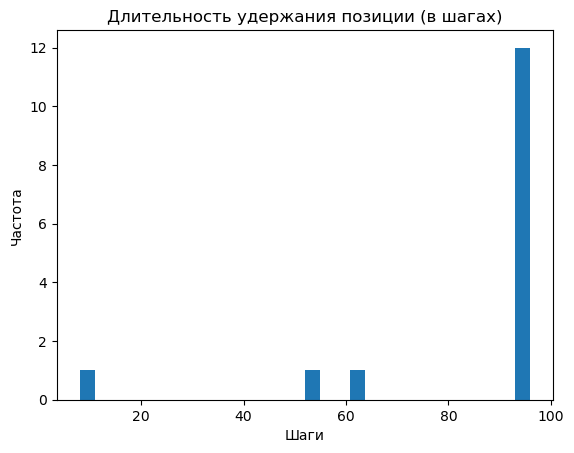

✅ Total reward: -7655.79
🔁 Total trades executed: 29
📉 Max drawdown: 216.64
📈 Sharpe Ratio: -1.50


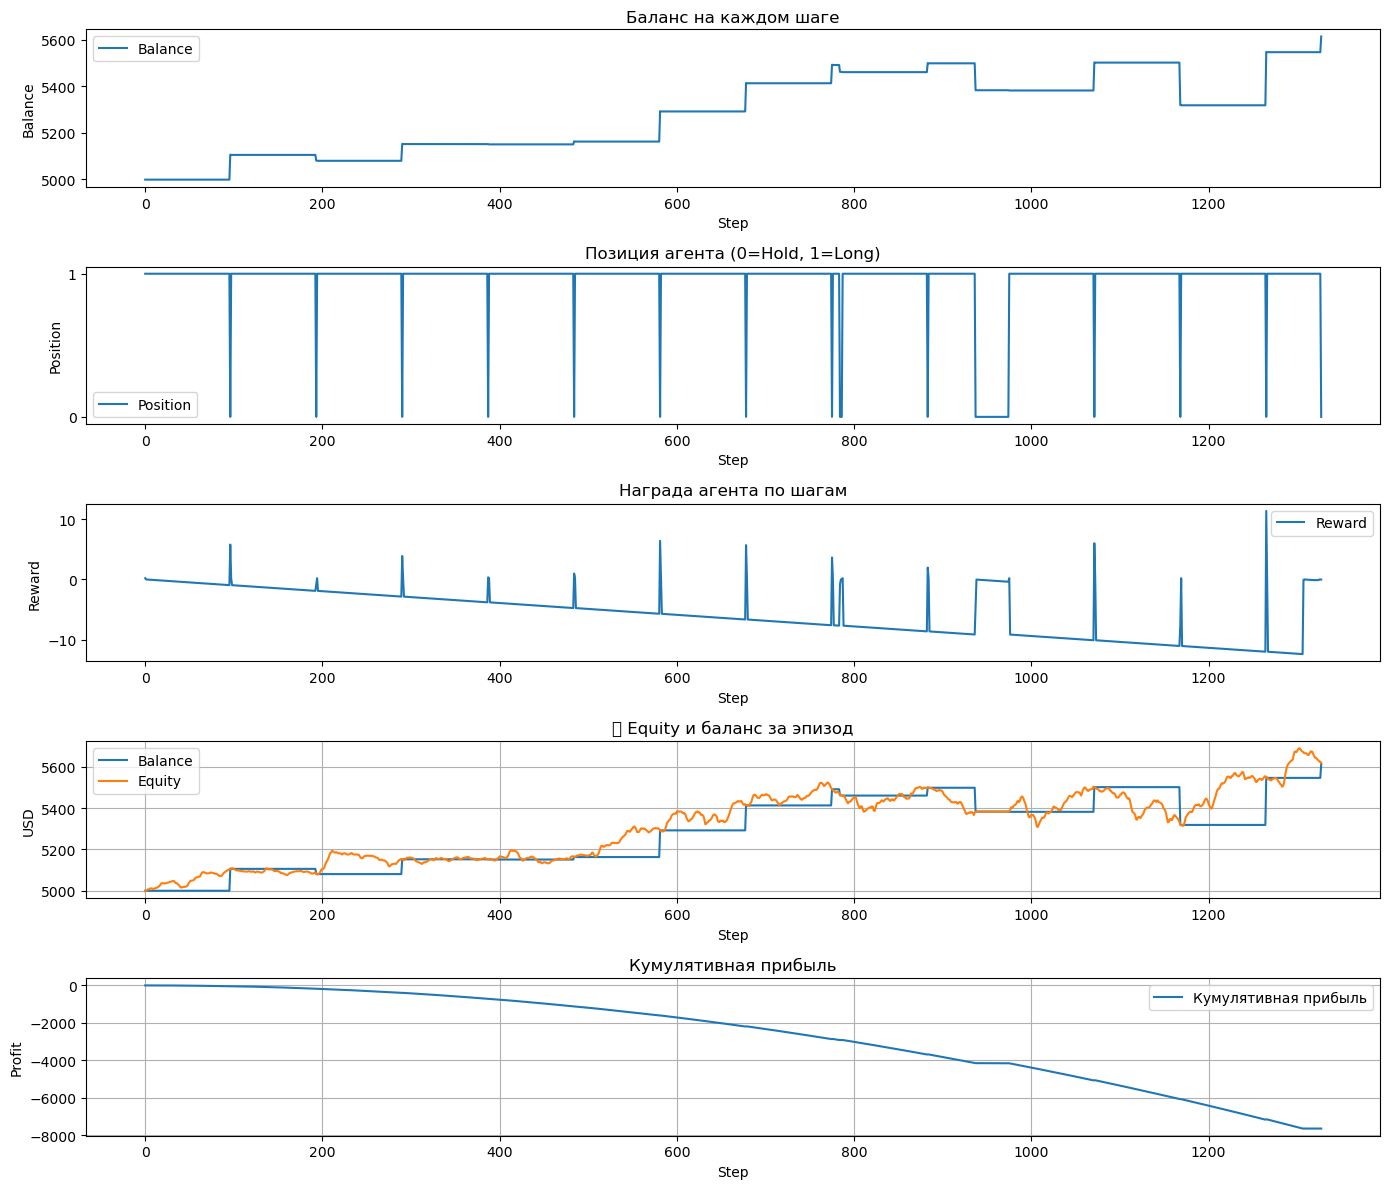

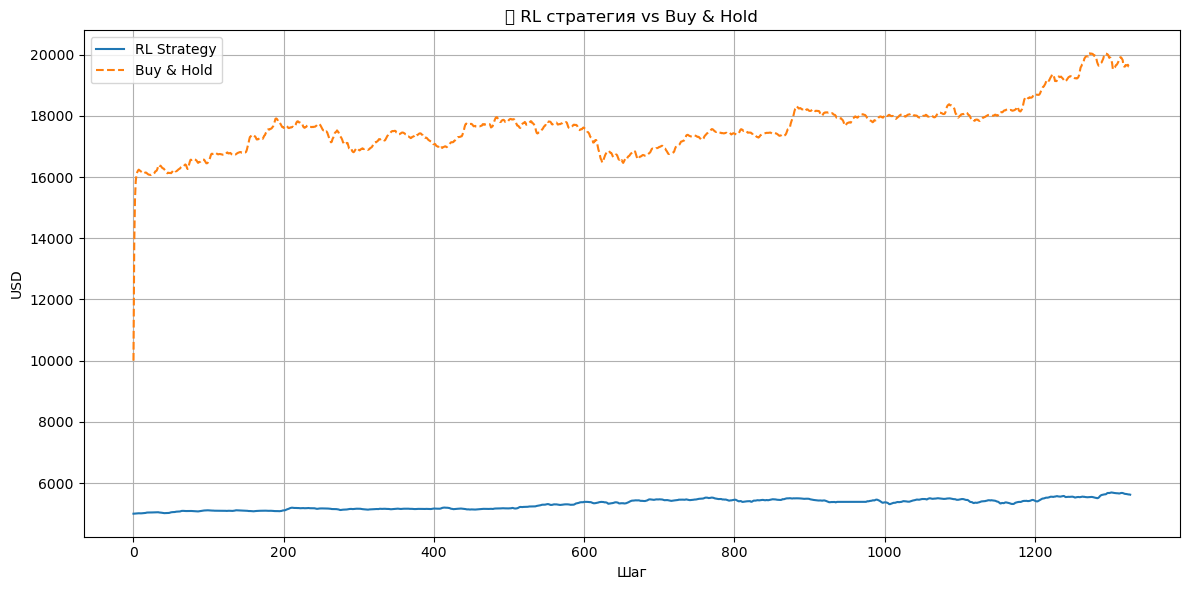


Общее число сделок: 55798
Средняя длительность сделки (в шагах): 3.03
Средняя прибыль на сделку: -0.00
Суммарная прибыль: -75.13


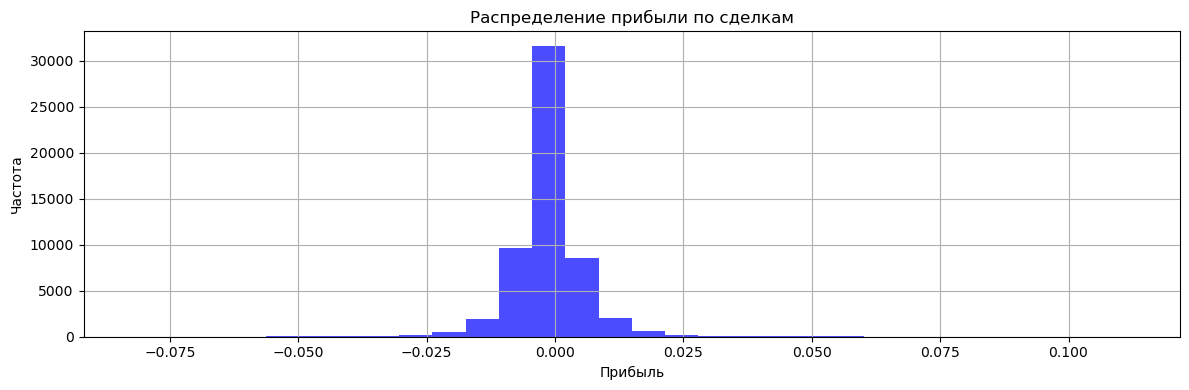

📊 Метрики по всем эпизодам:
▶ Средняя Total Reward: -7655.53
▶ Средний Sharpe Ratio: -1.50
▶ Средний Max Drawdown: 204.67
▶ Среднее число сделок: 55813.00
▶ Средняя прибыль на сделку: -0.00
▶ Средняя длительность сделки: 3.05 шагов


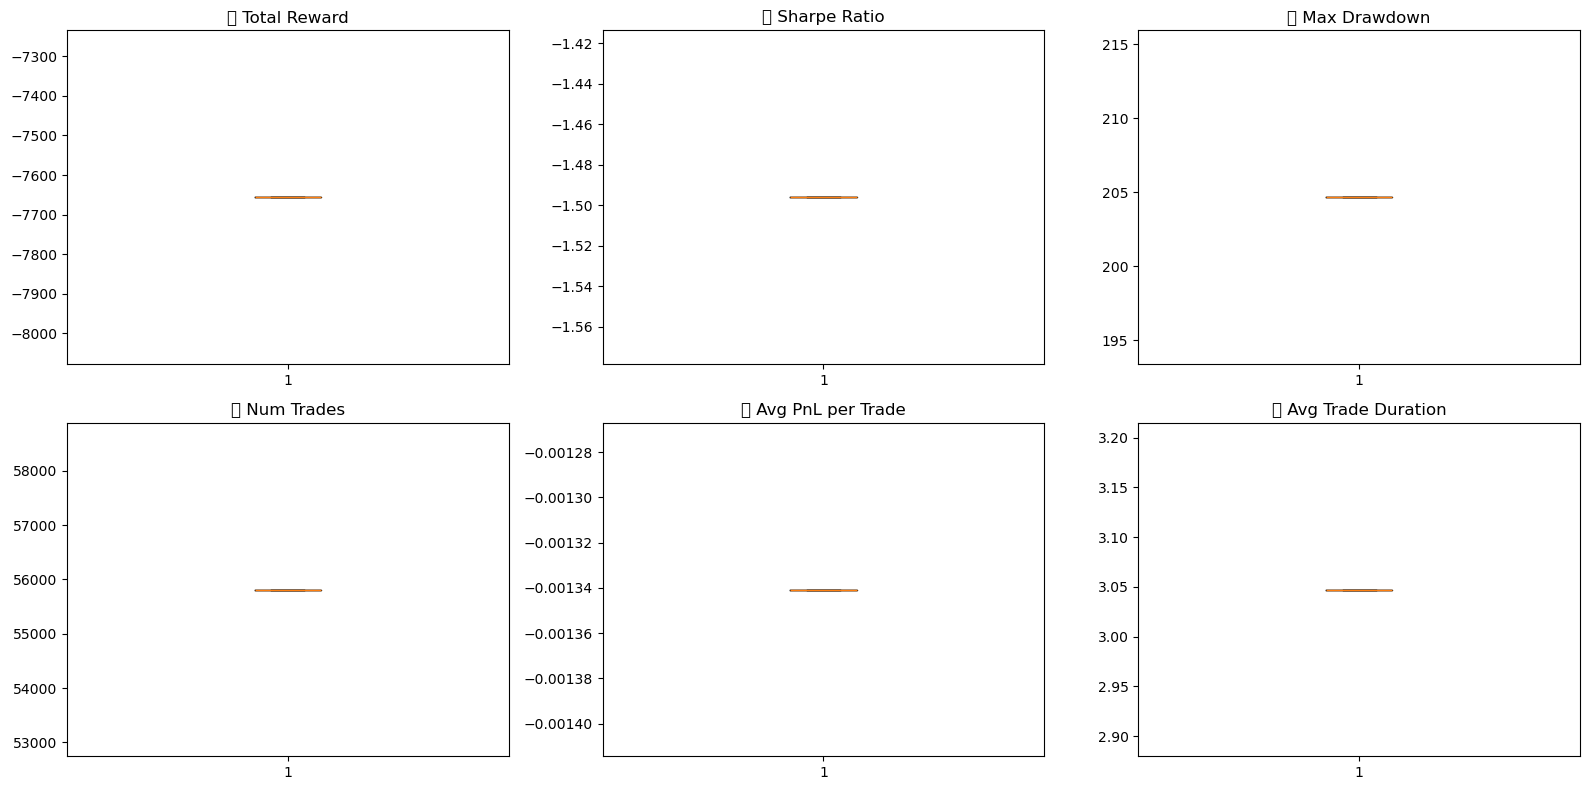

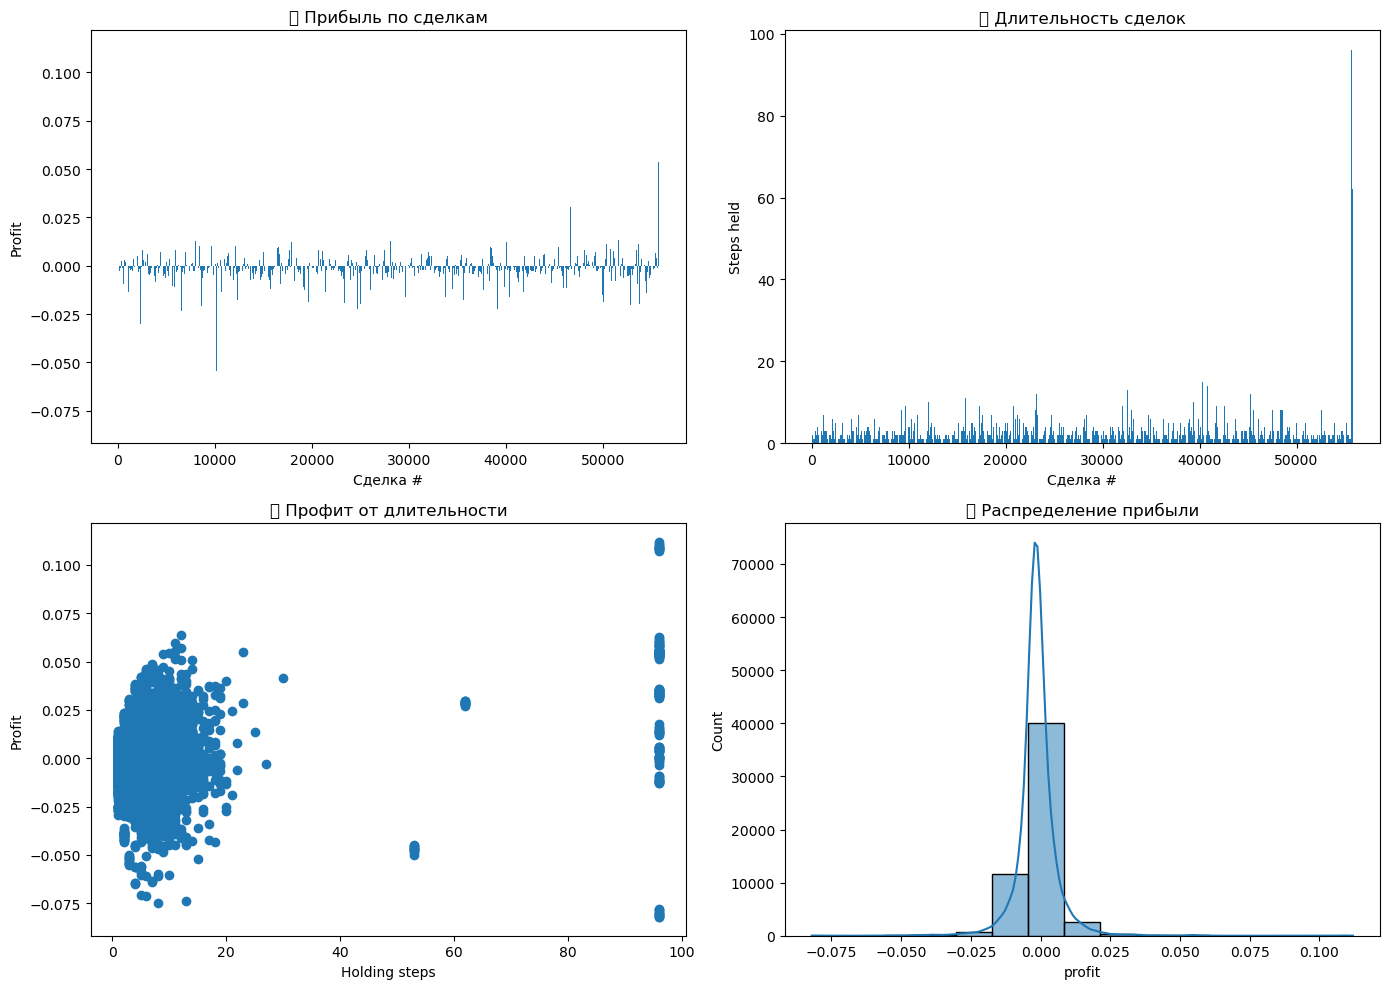

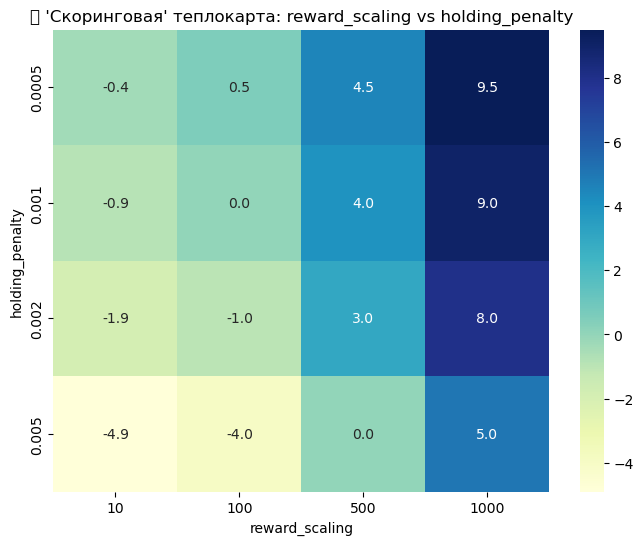

       entry_step  exit_step    profit   holding  entry_price  exit_price
count   55,813.00  55,813.00 55,813.00 55,813.00    55,813.00   55,813.00
mean     1,332.44   1,335.49     -0.00      3.05     2,241.13    2,240.28
std        382.96     382.98      0.01      5.18       141.01      140.51
min        672.00     673.00     -0.08      1.00     1,971.13    1,975.08
25%      1,001.00   1,004.00     -0.00      1.00     2,137.97    2,136.48
50%      1,333.00   1,336.00     -0.00      2.00     2,198.19    2,199.82
75%      1,664.00   1,668.00      0.00      4.00     2,373.40    2,372.03
max      1,999.00   2,000.00      0.11     96.00     2,538.55    2,533.12


In [37]:
test(vec_env_eth, model_eth, eth_with_ta, crypt="eth")

# Обучаем агента SOL

In [9]:
excluded = ['future_return', 'target']
state_columns_sol = [col for col in sol_with_ta.columns if col not in excluded]

In [10]:
def make_env_sol():
    return ETHTradingEnv(
        df=sol_with_ta,
        state_columns=state_columns_sol,
        initial_balance=5000,
        trade_penalty=0.01,
        max_steps=2000,
        reward_scaling=100,
        window_size=672  # 7 дней по 15 минут
    )

vec_env_sol = DummyVecEnv([make_env_sol])

In [ ]:
# 3. Обучим агента
model_sol = PPO(
    policy=TransformerPolicy,
    env=vec_env_sol,
    verbose=1,
    n_steps=4096,
    batch_size=64,
    gae_lambda=0.95,
    gamma=0.99,
    n_epochs=10,
    learning_rate=3e-4,
    clip_range=0.2,           # 👈 обязательно
    max_grad_norm=0.5,        # 👈 ограничим градиенты
    vf_coef=0.5,
    normalize_advantage=True,
    ent_coef=0.2  # <-- Ключевой параметр для стимула к исследованию
)
model_sol.learn(total_timesteps=300_000, progress_bar=True)

Using cuda device


Output()

-----------------------------
| time/              |      |
|    fps             | 225  |
|    iterations      | 1    |
|    time_elapsed    | 18   |
|    total_timesteps | 4096 |
-----------------------------


In [ ]:
model_sol.save("ppo_sol_trading_v1")